<a href="https://colab.research.google.com/github/aabelatilaw/-CodeAlpha_ProjectName-/blob/main/iris_flower_classification_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Iris Flower Classification with Machine Learning**

Step 1: Import Required Libraries

In [32]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_iris
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import joblib

Step 2: Load and Explore the Data

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Su

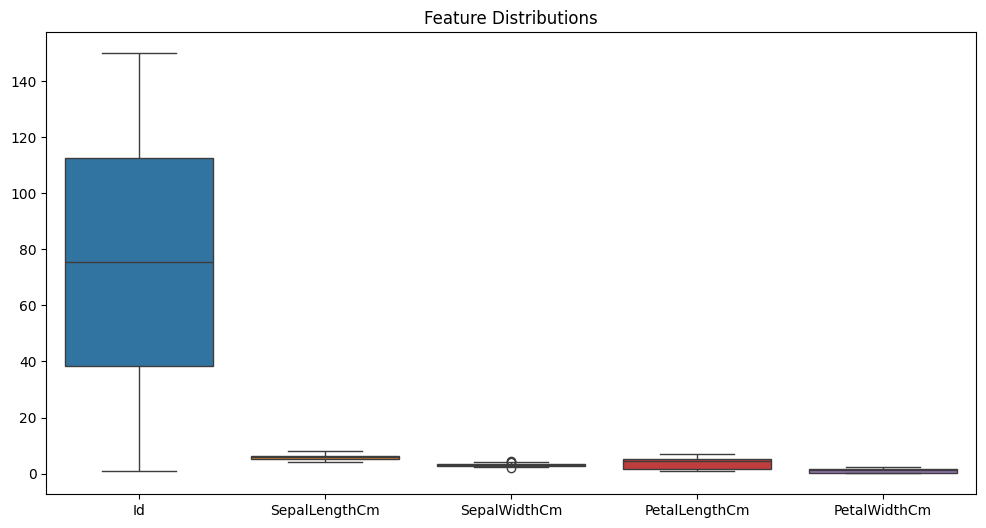

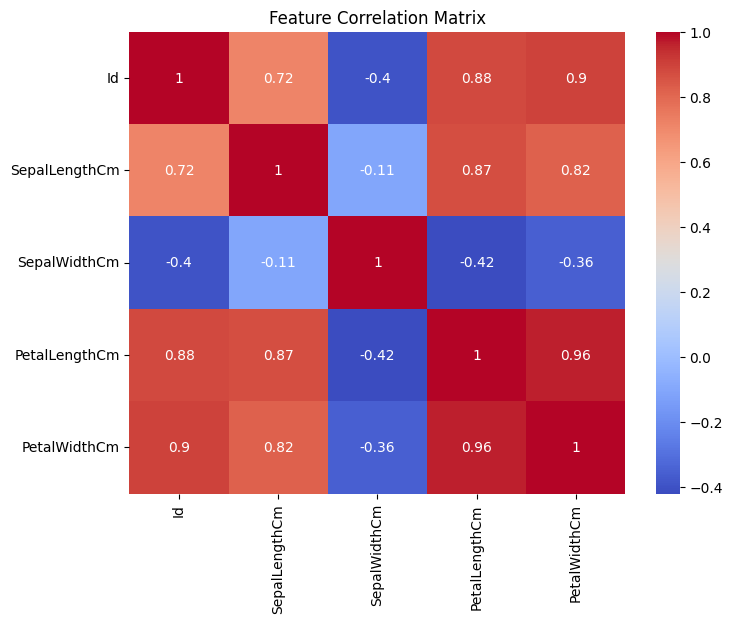

In [33]:
# Load the data


url = 'https://raw.githubusercontent.com/aabelatilaw/-CodeAlpha_ProjectName-/main/Iris.csv'

df = pd.read_csv(url)

# Explore the data
print(df.head())
print("\nData Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nSpecies Count:")
print(df['Species'].value_counts())

# Add new EDA visualizations here
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop('Species', axis=1))
plt.title('Feature Distributions')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(df.drop('Species', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

Step 3: Data Preprocessing

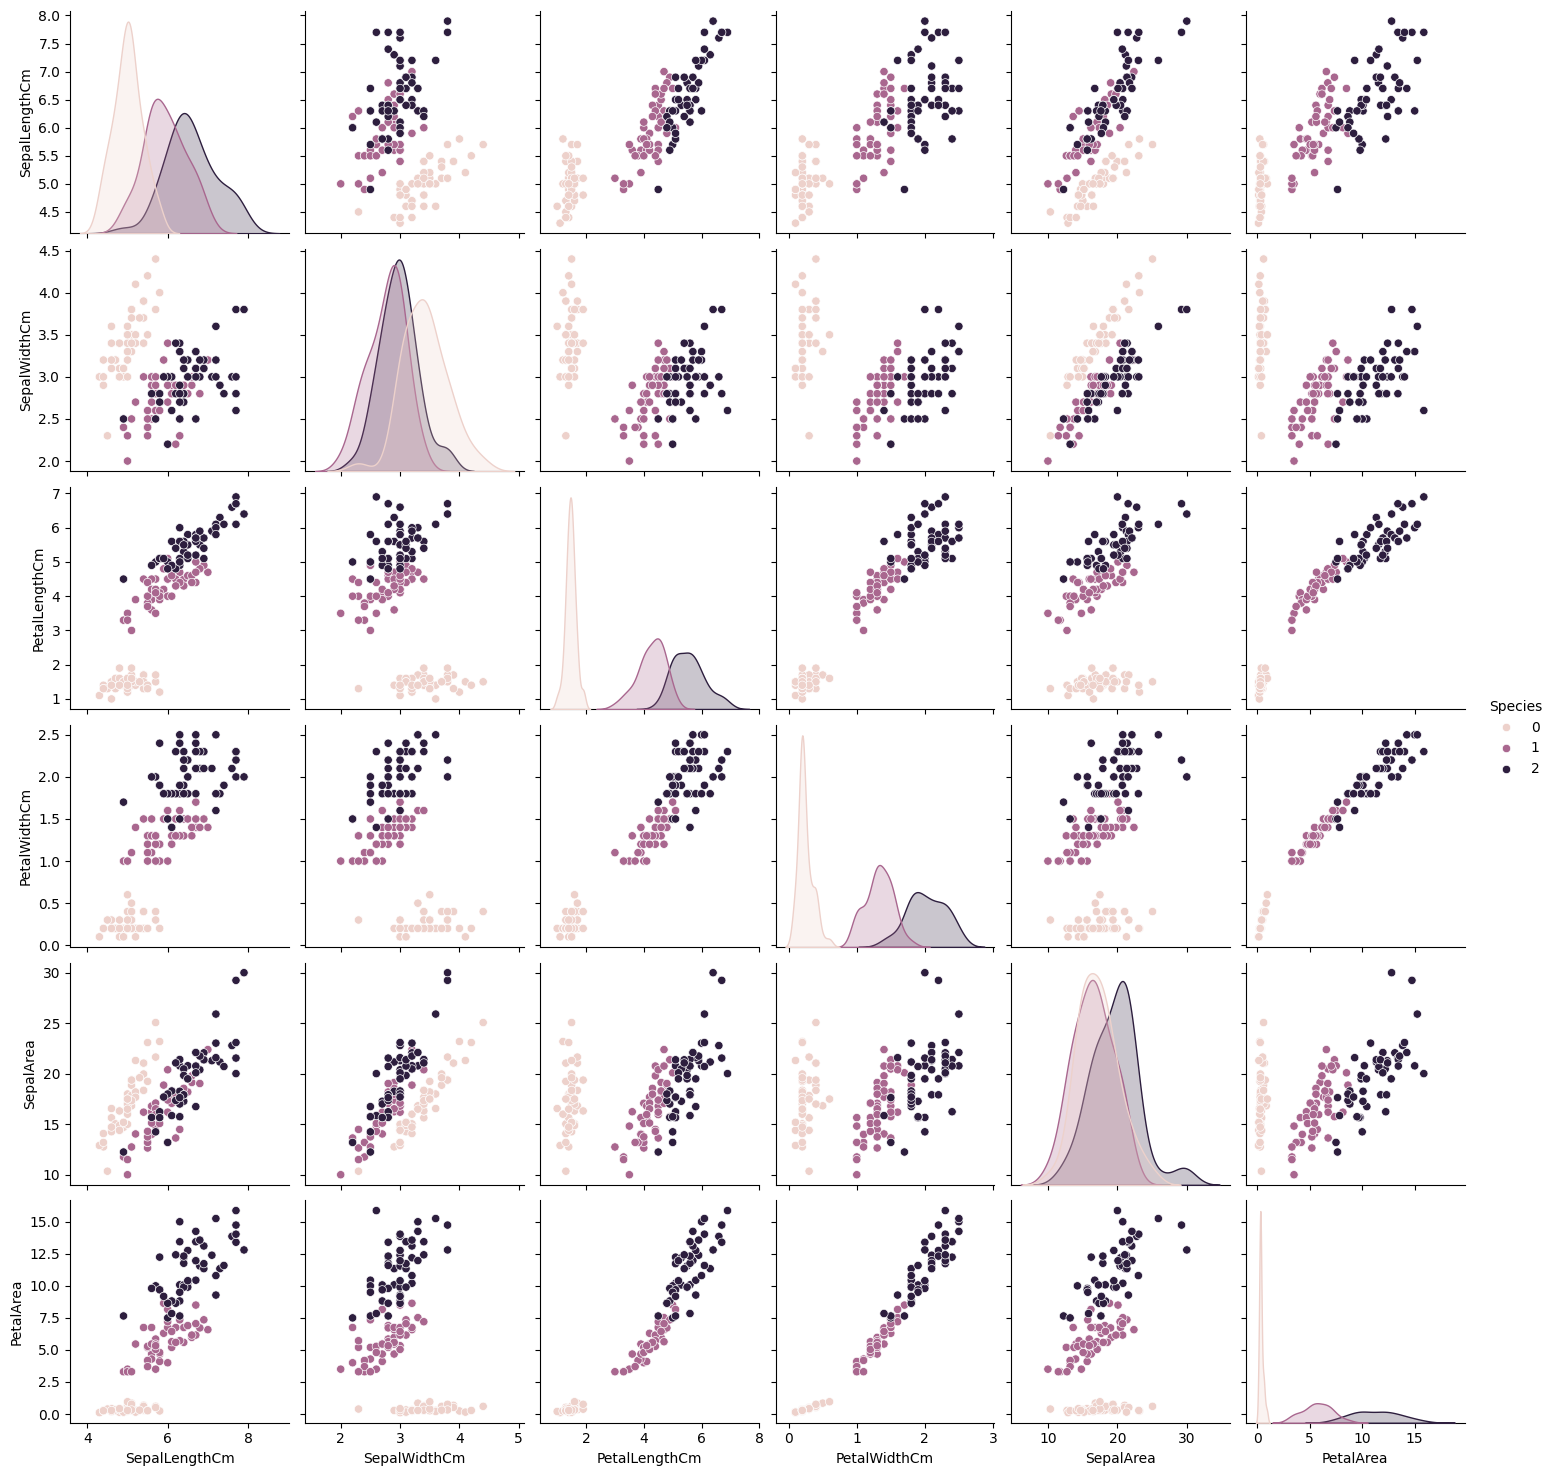

In [34]:
# Drop the Id column as it's not needed
df = df.drop('Id', axis=1)
label_encoder = LabelEncoder()
df['Species'] = label_encoder.fit_transform(df['Species'])

# Add feature engineering
df['SepalArea'] = df['SepalLengthCm'] * df['SepalWidthCm']
df['PetalArea'] = df['PetalLengthCm'] * df['PetalWidthCm']

# Visualize the data
sns.pairplot(df, hue='Species')
plt.show()


Model Training & Evaluation

Random Forest: 0.9500 (+/- 0.0612)
SVM: 0.9583 (+/- 0.0456)
KNN: 0.9583 (+/- 0.0645)
Best parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.9666666666666666
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


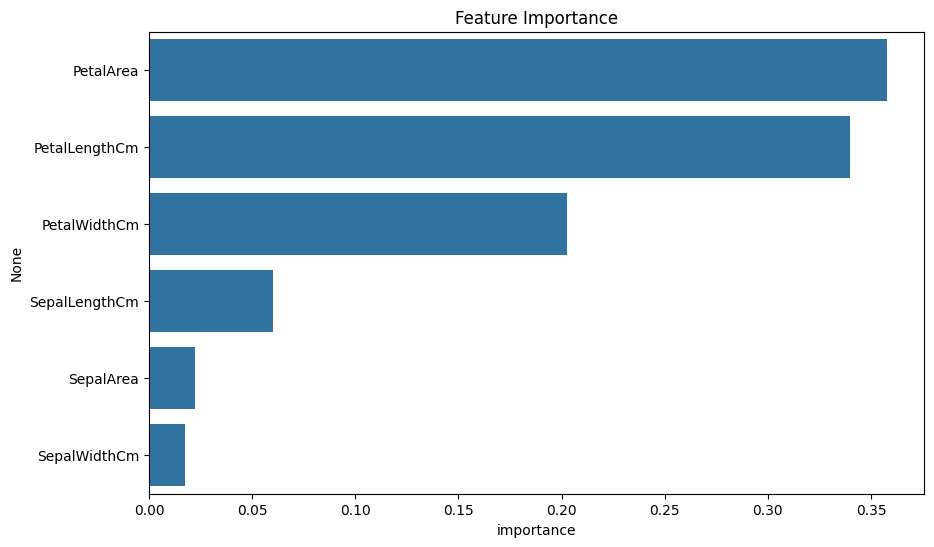

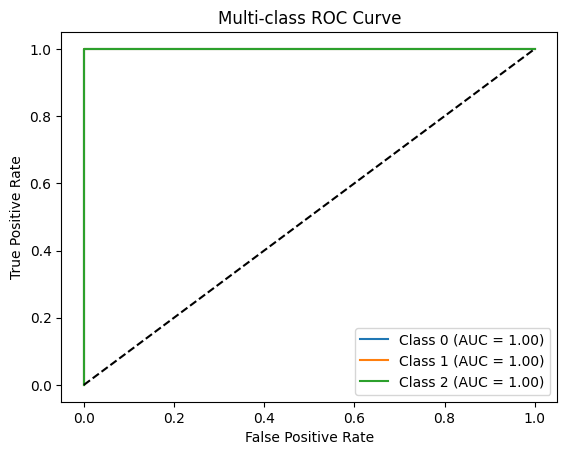

In [36]:
# Split data (update X to include new features if keeping them)
X = df.drop('Species', axis=1)
y = df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add model comparison
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Hyperparameter tuning (add after model comparison)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train final model with best parameters
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Enhanced evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importances = pd.DataFrame(
    clf.feature_importances_,
    index=X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()

# ROC Curve
y_test_bin = label_binarize(y_test, classes=[0,1,2])
y_score = clf.predict_proba(X_test)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(3):  # 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend()
plt.show()

**Model Deployment**

In [37]:
# Save the model and label encoder
joblib.dump(clf, 'iris_rf_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Example usage
loaded_model = joblib.load('iris_rf_model.pkl')
loaded_encoder = joblib.load('label_encoder.pkl')

sample = [[5.1, 3.5, 1.4, 0.2, 5.1*3.5, 1.4*0.2]]  # Include engineered features
prediction = loaded_model.predict(sample)
print("Predicted class:", loaded_encoder.inverse_transform(prediction))

Predicted class: ['Iris-setosa']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
